Loading KMNIST dataset...

Dataset loaded successfully!

Defining hyperparameters...

Hyperparameters defined.

Starting cross-validation for hyperparameter tuning...

Tuning hyperparameters for AdamW...

Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2CEE75E50>


c:\Users\karti\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Finished training. Test Accuracy: 0.9482, Test Loss: 0.1804

Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2DF7FCDA0>
Finished training. Test Accuracy: 0.9510, Test Loss: 0.1927

Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2E1193C20>
Finished training. Test Accuracy: 0.9486, Test Loss: 0.1992

Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2E34747A0>
Finished training. Test Accuracy: 0.9496, Test Loss: 0.1941

Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2CEF51A30>
Finished training. Test Accuracy: 0.9482, Test Loss: 0.1974

Avg Validation Accuracy for AdamW with lr=0.001, wd=0.001: 0.9491
Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2E784BF80>
Finished training. Test Accuracy: 0.9514, Test Loss: 0.1790

Training model with optimizer: <keras.src.optimizers.adamw.AdamW object at 0x000001A2E77621B0

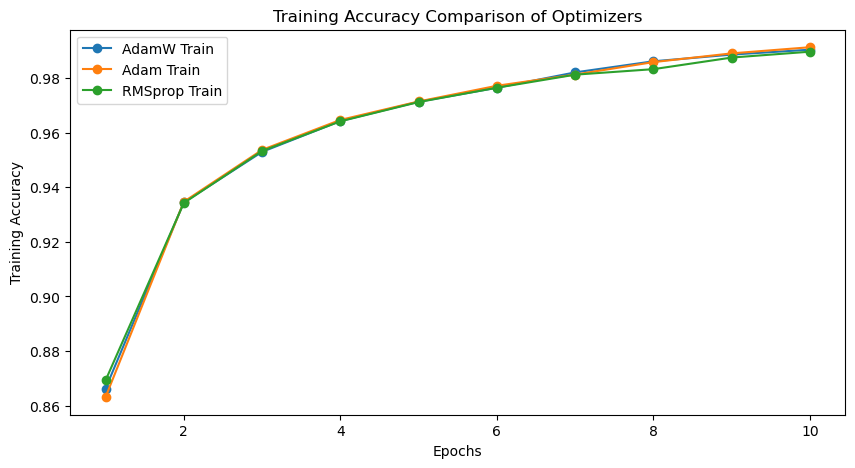

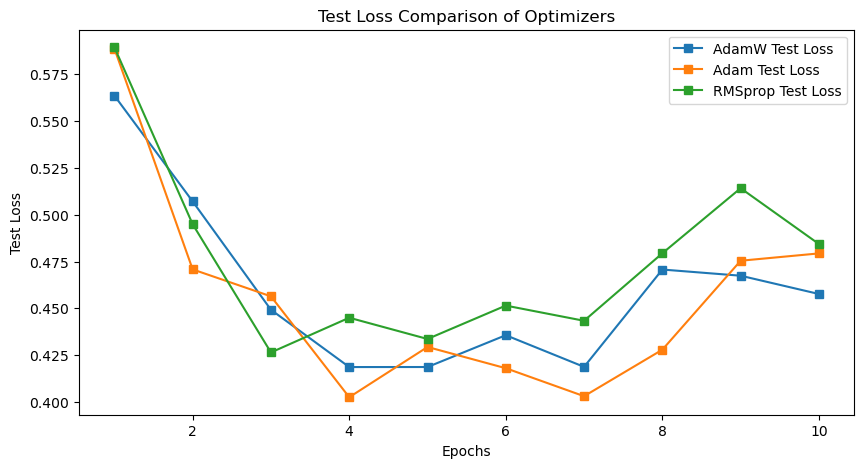

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

# Load KMNIST dataset
print("Loading KMNIST dataset...\n")
dataset, info = tfds.load("kmnist", as_supervised=True, with_info=True)

# Convert dataset to NumPy arrays
x_train = np.array([x.numpy() for x, _ in dataset['train']])
y_train = np.array([y.numpy() for _, y in dataset['train']])
x_test = np.array([x.numpy() for x, _ in dataset['test']])
y_test = np.array([y.numpy() for _, y in dataset['test']])

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)
print("Dataset loaded successfully!\n")

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Define hyperparameters
print("Defining hyperparameters...\n")
tuning_params = {
    "AdamW": {
        "learning_rates": [0.001, 0.0005],
        "weight_decays": [0.001, 0.0005],
        "alpha": 0.001, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-7
    },
    "Adam": {
        "learning_rates": [0.001, 0.0005],
        "alpha": 0.001, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-7
    },
    "RMSprop": {
        "learning_rates": [0.001, 0.0005],
        "rho": 0.9
    }
}
print("Hyperparameters defined.\n")

def train_and_evaluate(model, optimizer, x_train, y_train, x_test, y_test, epochs=10):
    print(f"Training model with optimizer: {optimizer}")
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=0, validation_data=(x_test, y_test))
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Finished training. Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}\n")
    return history.history['accuracy'], history.history['val_loss'], test_acc, test_loss

def cross_validate_hyperparameters(x_train, y_train, k=5, epochs=10):
    print("Starting cross-validation for hyperparameter tuning...\n")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    best_params = {}
    tuning_results = []
    
    for optimizer_name, params in tuning_params.items():
        print(f"Tuning hyperparameters for {optimizer_name}...\n")
        best_acc = 0
        best_hyperparams = None
        for lr in params.get("learning_rates", []):
            for wd in params.get("weight_decays", [0]):
                accuracies = []
                for train_idx, val_idx in kf.split(x_train):
                    x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
                    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
                    
                    model = build_model()
                    if optimizer_name == "Adam":
                        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                    elif optimizer_name == "RMSprop":
                        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=params["rho"])
                    elif optimizer_name == "AdamW":
                        optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
                    
                    _, _, val_acc, _ = train_and_evaluate(model, optimizer, x_train_fold, y_train_fold, x_val_fold, y_val_fold, epochs)
                    accuracies.append(val_acc)
                
                avg_acc = np.mean(accuracies)
                tuning_results.append([optimizer_name, lr, wd, avg_acc])
                print(f"Avg Validation Accuracy for {optimizer_name} with lr={lr}, wd={wd}: {avg_acc:.4f}")
                if avg_acc > best_acc:
                    best_acc = avg_acc
                    best_hyperparams = {'lr': lr, 'weight_decay': wd}
        
        best_params[optimizer_name] = best_hyperparams
    
    print("\nSaving hyperparameter tuning results...\n")
    pd.DataFrame(tuning_results, columns=['Optimizer', 'Learning Rate', 'Weight Decay', 'Validation Accuracy']).to_csv('hyperparameter_tuning_results.csv', index=False)
    print("Hyperparameter tuning results saved!\n")
    return best_params

best_hyperparameters = cross_validate_hyperparameters(x_train, y_train)

# Store history for each optimizer
history_dict = {}

# Train final models for each optimizer using their best hyperparameters
final_results = {}
train_accuracies = {}
test_losses = {}
final_model_results = []

print("Training final models with best hyperparameters...\n")

for optimizer_name, params in best_hyperparameters.items():
    print(f"Training final model for {optimizer_name}...\n")
    model = build_model()
    
    # Compile the model with the best optimizer
    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
    elif optimizer_name == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['lr'], rho=tuning_params["RMSprop"]["rho"])
    elif optimizer_name == "AdamW":
        optimizer = tf.keras.optimizers.AdamW(learning_rate=params['lr'], weight_decay=params['weight_decay'])
    
    # Call compile here explicitly to avoid the error
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))
    
    # Store the history of the optimizer
    history_dict[optimizer_name] = {
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss']
    }
    
    final_results[optimizer_name] = history.history['val_accuracy'][-1]
    train_accuracies[optimizer_name] = history.history['accuracy']
    test_losses[optimizer_name] = history.history['val_loss'][-1]
    
    # Store final model results
    final_model_results.append({
        'Optimizer': optimizer_name,
        'Test Accuracy': final_results[optimizer_name],
        'Test Loss': test_losses[optimizer_name]
    })

# Save final model results to CSV
pd.DataFrame(final_model_results).to_csv('final_model_results.csv', index=False)
print("\nFinal model results saved!\n")

# Plot training accuracy
plt.figure(figsize=(10, 5))
for optimizer, history in history_dict.items():
    plt.plot(range(1, 11), history['accuracy'], label=f"{optimizer} Train", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.title("Training Accuracy Comparison of Optimizers")
plt.show()

# Plot test loss
plt.figure(figsize=(10, 5))
for optimizer, history in history_dict.items():
    plt.plot(range(1, 11), history['val_loss'], label=f"{optimizer} Test Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss Comparison of Optimizers")
plt.show()
